In [22]:
# h5, loom
library(rhdf5)
library(Matrix)
library(SingleCellExperiment)
library(MetaNeighbor)
library(MetaMarkers)
library(dplyr)

In [47]:
# cell-type annotation
mtd = read.delim('~/heart/zebrafish/final_celltypes.tsv.txt', sep = ',')
head(mtd)
dim(mtd)

Cell                orig.ident nCount_RNA nFeature_RNA percent.mito time
1 H5_AAACCTGAGACTACAA H5         1112       337          17.535971    Ctrl
2 H5_AAACGGGAGGCGCTCT H5          834       366           6.714628    Ctrl
3 H5_AAAGATGAGATCCCAT H5         1604       510           1.807980    Ctrl
4 H5_AAAGATGCATCAGTCA H5         3244       577           4.562269    Ctrl
5 H5_AAAGATGTCGATAGAA H5         1079       426           7.321594    Ctrl
6 H5_AAATGCCGTACCGCTG H5          942       272          22.929936    Ctrl
  morphine AV         inhib so.far.ident.subtypes ⋯ paper.ident   
1 Ctrl     Wholeheart NULL  Atrium                ⋯ Cardiomyocytes
2 Ctrl     Wholeheart NULL  Atrium                ⋯ Cardiomyocytes
3 Ctrl     Wholeheart NULL  Atrium                ⋯ Cardiomyocytes
4 Ctrl     Wholeheart NULL  Atrium                ⋯ Cardiomyocytes
5 Ctrl     Wholeheart NULL  Atrium                ⋯ Cardiomyocytes
6 Ctrl     Wholeheart NULL  Atrium                ⋯ Cardiomyocytes
  RNA_snn_res.2 RNA_snn_res.3 RNA_snn_res.3.5 work.ident2    work.ident3     
1 19            10            10              Cardiomyocytes Cardiomyocytes A
2 14            35            27              Cardiomyocytes Cardiomyocytes A
3 31            23            27              Cardiomyocytes Cardiomyocytes A
4 14            23            27              Cardiomyocytes Cardiomyocytes A
5 14            35            27              Cardiomyocytes Cardiomyocytes A
6 14            35            27              Cardiomyocytes Cardiomyocytes A
  final.zoom       lineage.ident    Cell_type              
1 Cardiomyocytes A Cardiomyocytes A Cardiomyocytes (Atrium)
2 Cardiomyocytes A Cardiomyocytes A Cardiomyocytes (Atrium)
3 Cardiomyocytes A Cardiomyocytes A Cardiomyocytes (Atrium)
4 Cardiomyocytes A Cardiomyocytes A Cardiomyocytes (Atrium)
5 Cardiomyocytes A Cardiomyocytes A Cardiomyocytes (Atrium)
6 Cardiomyocytes A Cardiomyocytes A Cardiomyocytes (Atrium)
  Cell_name            
1 ndH5_AAACCTGAGACTACAA
2 ndH5_AAACGGGAGGCGCTCT
3 ndH5_AAAGATGAGATCCCAT
4 ndH5_AAAGATGCATCAGTCA
5 ndH5_AAAGATGTCGATAGAA
6 ndH5_AAATGCCGTACCGCTG

[1] 202075     31

In [54]:
table(mtd$orig.ident)


   H5    H6    H7   H8a   H8v   Hr1  Hr10  Hr11  Hr12  Hr13  Hr14  Hr15  Hr19 
 2095  3443  8526  5244  3728 13017 10063  9887  6869  3835  5449  5207   414 
 Hr20  Hr21  Hr22  Hr23  Hr24  Hr25  Hr26  Hr27  Hr28  Hr29  Hr2a  Hr2b   Hr3 
  418   456  2139  2689  4550  1140  8080  5858  3739  1827 10827 11179  8571 
 Hr30  Hr31  Hr32  Hr33  Hr34  Hr35   Hr4  Hr6a  Hr6v  Hr7a  Hr7v   Hr8   Hr9 
 3345  1767  1420  1136  5633  7188  7367  2851  7849  4329  5508  5604  8828 

In [71]:
table(mtd$Cell_type[mtd$orig.ident=='H5'])


                       B-cells              Bl.ves.EC (apnln) 
                            49                             84 
             Bl.ves.EC (lyve1)             Bl.ves.EC (plvapb) 
                             6                             16 
       Cardiomyocytes (Atrium) Cardiomyocytes (proliferating) 
                           438                              3 
        Cardiomyocytes (ttn.2)     Cardiomyocytes (Ventricle) 
                           101                            267 
          Endocardium (Atrium)             Endocardium (frzb) 
                           230                             85 
       Endocardium (Ventricle)            Epicardium (Atrium) 
                           195                             10 
        Epicardium (Ventricle)              Fibroblasts (cfd) 
                            17                             16 
          Fibroblasts (const.)          Fibroblasts (cxcl12a) 
                           112                        

In [33]:
file1 = '~/heart/zebrafish/GSM4817928_H5_filtered_matrix.h5'
h5ls(file1)

group            name          otype       dclass  dim    
0  /                matrix        H5I_GROUP                  
1  /matrix          barcodes      H5I_DATASET STRING  3745   
2  /matrix          data          H5I_DATASET INTEGER 2244227
3  /matrix          features      H5I_GROUP                  
4  /matrix/features _all_tag_keys H5I_DATASET STRING  1      
5  /matrix/features feature_type  H5I_DATASET STRING  31466  
6  /matrix/features genome        H5I_DATASET STRING  31466  
7  /matrix/features id            H5I_DATASET STRING  31466  
8  /matrix/features name          H5I_DATASET STRING  31466  
9  /matrix          indices       H5I_DATASET INTEGER 2244227
10 /matrix          indptr        H5I_DATASET INTEGER 3746   
11 /matrix          shape         H5I_DATASET INTEGER 2

In [37]:
ind = h5read(file1, '/matrix/indices')
indp = h5read(file1, '/matrix/indptr')
xmat = h5read(file1, '/matrix/data')
ctypes = h5read(file1, '/matrix/barcodes')
genes = h5read(file1, '/matrix/features/id')
dimn = h5read(file1, '/matrix/shape')

In [38]:
# make sparse matrix
mat = sparseMatrix(i = ind, p = indp, x = xmat, dims = dimn)
dim(mat)

[1] 31466  3745

In [72]:
# make SCE object
adata = SingleCellExperiment(list(counts = mat))
rownames(adata) = genes
colnames(adata) = ctypes

In [50]:
head(ctypes)

[1] "AAACCTGAGACTACAA-1" "AAACCTGAGCACGCCT-1" "AAACCTGAGGATGTAT-1"
[4] "AAACCTGAGTCCATAC-1" "AAACCTGAGTGAATTG-1" "AAACCTGGTCTCATCC-1"

In [75]:
# modify cell names and prune adata
ctypes2 = paste0('H5_', sub("\\-.*", "", ctypes))
colnames(adata) = ctypes2
match(ctypes2, mtd$Cell)[1:20]
adata <- adata[,which(!is.na(match(colnames(adata), mtd$Cell)))]

[1]     1 20576 21111  7152  9661  3009 21112    NA  3147  9662  3148     2
[13]    NA 21113 18461    NA 18462     3  9663    NA

In [76]:
dim(adata)
assay(adata, "cpm") = convert_to_cpm(assay(adata))

[1] 31466  2095

In [ ]:
# add rowdata
zinfo = read.delim('/data/CoCoCoNet/geneInfo/zebrafish_info.csv', sep = ',')
rowData(adata)$Gene = rownames(adata)
rowData(adata)$Symbol = zinfo$GeneSymbol[match(rownames(adata), zinfo$EnsemblID)]

In [77]:
# add coldata
colData(adata)$Cluster <- mtd$Cell_type[match(colnames(adata), mtd$Cell)]
colData(adata)$Dataset <- mtd$orig.ident[match(colnames(adata), mtd$Cell)]

In [59]:
aa = read.delim('~/heart/GSE106118_UMI_count_merge.txt', sep = '\t')
cls = read.delim('~/heart/cui_cluster_anno.csv', sep = ',')
# barcodes = read.delim('~/heart/GSE106118_barcode_information.txt', sep = '\t')

ginfo = read.delim('/data/CoCoCoNet/geneInfo/human_info.csv', sep = ',')

In [60]:
genes2 = unlist(aa[,1])
aa <- as.matrix(aa[,-1])
rownames(aa) = genes2

In [63]:
# subset to 3842 cells with anno
mat2 = aa[,which(!is.na(match(colnames(aa), cls$Cell.Name)))]

# SCE object
mat2 = SingleCellExperiment(mat2)
colData(mat2)$Cluster = cls$Cluster[match(colnames(mat2), cls$Cell.Name)]
colData(mat2)$Dataset = 'Cui'
rownames(colData(mat2)) = colnames(mat2)

rownames(mat2) <- ginfo$EnsemblID[match(rownames(mat2), ginfo$GeneSymbol)]
mat2 <- mat2[!is.na(rownames(mat2)),]
rowData(mat2)$Gene = rownames(mat2)
rowData(mat2)$Symbol = ginfo$GeneSymbol[match(rownames(mat2), ginfo$EnsemblID)]

assay(mat2, "cpm") = convert_to_cpm(assay(mat2))
assayNames(mat2) <- c('counts', 'cpm')

In [64]:
om = read.delim('/data/CoCoCoNet/orthologMaps/zebrafish_human_orthoNM.csv', sep = ',')
om[1:3,]

zebrafish          human           zebrafish_OrthoID human_OrthoID
1 ENSDARG00000063922 ENSG00000198695 7955_0:0072ac     9606_0:000000
2 ENSDARG00000063914 ENSG00000198840 7955_0:0072ad     9606_0:000001
3 ENSDARG00000063899 ENSG00000198763 7955_0:0072b0     9606_0:000002

In [69]:
mat2

class: SingleCellExperiment 
dim: 20855 3842 
metadata(0):
assays(2): counts cpm
rownames(20855): ENSG00000121410 ENSG00000268895 ... ENSG00000074755
  ENSG00000036549
rowData names(2): Gene Symbol
colnames(3842): HE5W_1_LA.1 HE5W_1_LA.3 ... HE23W_2_RV.22 HE23W_2_RV.24
colData names(2): Cluster Dataset
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [78]:
# subset to 1-1 orthologs
rownames(adata) <- om$human[match(rownames(adata), om$zebrafish)]
adata <- adata[!is.na(rownames(adata)),]
dim(adata)

[1] 17683  2095

In [79]:
# subset to common genes
cgenes = intersect(rownames(mat2), rownames(adata))
mat2 <- mat2[cgenes,]
adata <- adata[cgenes,]

In [80]:
rowData(adata) <- rowData(mat2)
adata

class: SingleCellExperiment 
dim: 9654 2095 
metadata(0):
assays(2): counts cpm
rownames(9654): ENSG00000175899 ENSG00000184389 ... ENSG00000074755
  ENSG00000036549
rowData names(2): Gene Symbol
colnames(2095): H5_AAACCTGAGACTACAA H5_AAACCTGAGCACGCCT ...
  H5_TTTGGTTGTGGGTCAA H5_TTTGTCATCAACACCA
colData names(2): Cluster Dataset
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [ ]:
# ..... MN ..... #

In [81]:
start.time <- Sys.time()
genes22 = variableGenes(mat2, exp_labels = mat2$Cluster)
# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

length(genes22)

Time difference of 1.479781 secs

[1] 88

In [82]:
data1 = mat2[genes22,]
data2 = adata[genes22,]
newmat = cbind(data1, data2)
dim(newmat)

[1]   88 5937

In [83]:
start.time <- Sys.time()

auroc1 = MetaNeighborUS(var_genes = genes22, dat = newmat, study_id = newmat$Dataset, 
    cell_type = newmat$Cluster, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = FALSE)

auroc2 = MetaNeighborUS(var_genes = genes22, dat = newmat, study_id = newmat$Dataset, 
    cell_type = newmat$Cluster, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = FALSE)


end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 0.1854367 secs

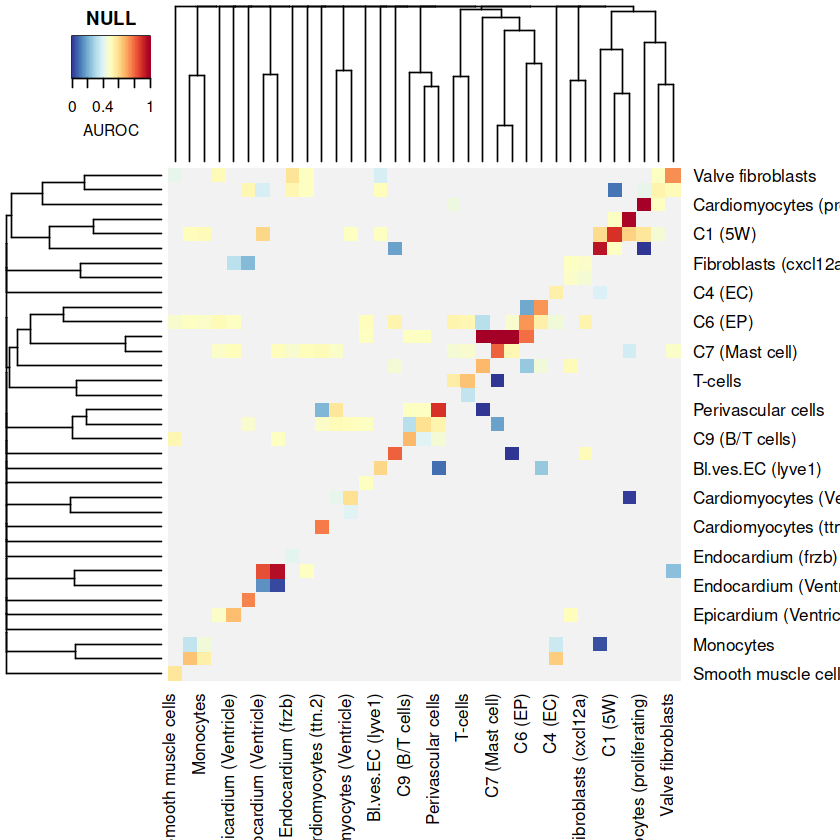

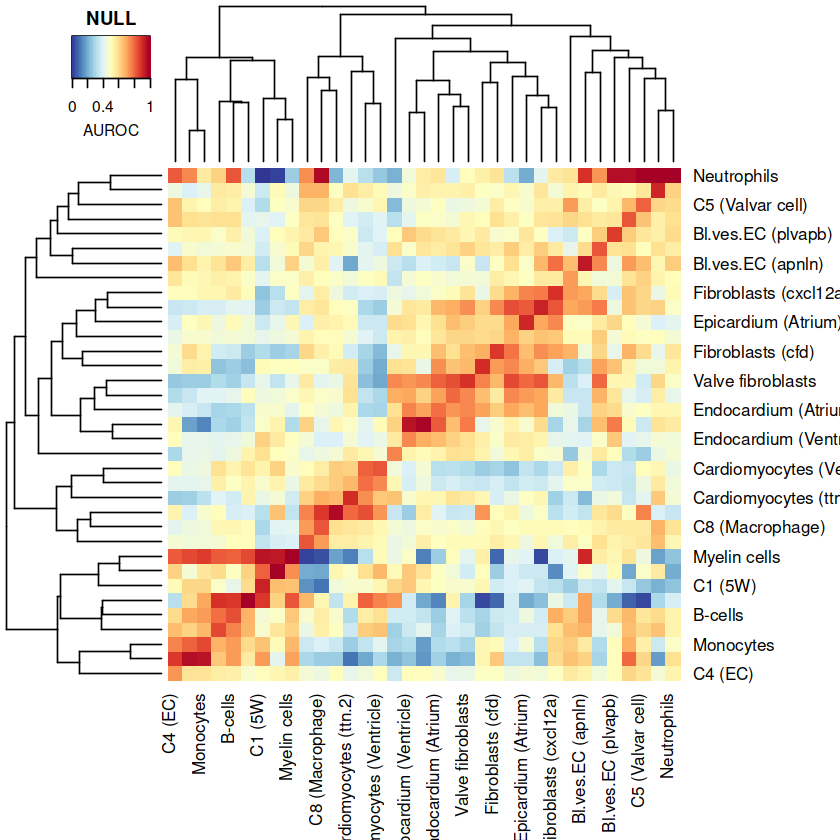

In [96]:
# png('chick_D14_1vsbest.png', width = 10, height = 10, res = 300, units = 'in')
currmat = auroc1
rownames(currmat) <- sub(".*\\|", "", rownames(auroc1))
colnames(currmat) = rownames(currmat)
MetaNeighbor::plotHeatmap(currmat, cex = 1)
# dev.off()

# png('Hu_Cui_allvsall.png', width = 10, height = 10, res = 300, units = 'in')
currmat = auroc2
rownames(currmat) <- sub(".*\\|", "", rownames(auroc1))
colnames(currmat) = rownames(currmat)
MetaNeighbor::plotHeatmap(currmat, cex = 1)
# dev.off()

In [ ]:
# also do cell type enrichment for marker gene sets in Hu et al data

In [85]:
markers = read.delim('~/heart/human_heart_dev_markers.csv', sep = ',')
markers[1:3,]

Gene   Celltype     
1 MYBPC3 Cardiomyocyte
2 RBM20  Cardiomyocyte
3 RYR2   Cardiomyocyte

In [86]:
# Cui et al 3.8k cells dataset
top_markers = data.frame(gene = ginfo$EnsemblID[match(markers[,1], ginfo$GeneSymbol)], cell_type = as.factor(markers[,2]), group = 'sim_SI')
ct_scores = score_cells(log1p(cpm(mat2)), top_markers)
ct_enrichment = compute_marker_enrichment(ct_scores)
ct_pred = assign_cells(ct_scores)
ct_pred$anno = mat2$Cluster

In [87]:
# verify in original Cui et al data
table(ct_pred$anno)
table(ct_pred$predicted[grep('C1', ct_pred$anno)])


                  C1 (5W)                   C2 (CM) C3 (Fibroblast-like cell) 
                      257                      1492                       786 
                  C4 (EC)          C5 (Valvar cell)                   C6 (EP) 
                      445                       427                        46 
           C7 (Mast cell)           C8 (Macrophage)            C9 (B/T cells) 
                       27                       304                        58 


Cardiomyocyte    Epicardial    Fibroblast    unassigned 
          246             4             6             1 

In [88]:
# ........ now on Hu's dataset ......... #
ct_scores = score_cells(log1p(cpm(adata)), top_markers)
ct_enrichment = compute_marker_enrichment(ct_scores)
ct_pred = assign_cells(ct_scores)
ct_pred$anno = adata$Cluster

In [89]:
table(ct_pred$predicted)


Cardiomyocyte   Endothelial    Epicardial    Fibroblast        Immune 
            1             5            36            77            34 
       Neuron           SMC    unassigned 
           13           610          1319 

In [92]:
outmat = ct_pred %>% group_by(anno, predicted) %>% summarize(sumAmount = length(predicted))
head(outmat)

`summarise()` has grouped output by 'anno'. You can override using the `.groups` argument.


anno              predicted  sumAmount
1 B-cells           Fibroblast  1       
2 B-cells           Immune      1       
3 B-cells           SMC         1       
4 B-cells           unassigned 46       
5 Bl.ves.EC (apnln) Fibroblast  1       
6 Bl.ves.EC (apnln) SMC         7

In [93]:
new2 = matrix(0, nrow = length(unique(ct_pred$anno)), ncol = 8)
colnames(new2) = unique(ct_pred$predicted)[1:8]
rownames(new2) = unique(ct_pred$anno) #paste0('cluster_', 1:20)

# map df to matrix
ids = cbind(match(unlist(outmat[,1]), rownames(new2)), match(unlist(outmat[,2]), colnames(new2)), outmat$sumAmount)
ids <- ids[which(!is.na(ids[,2])),]
for(ii in 1:dim(ids)[1])  {new2[ids[ii,1],ids[ii,2]] <- ids[ii,3]}

# get fraction of cell type
outmat2 = sweep(new2, 1, rowSums(new2), FUN = '/')

corrplot 0.92 loaded

Loading required package: viridisLite



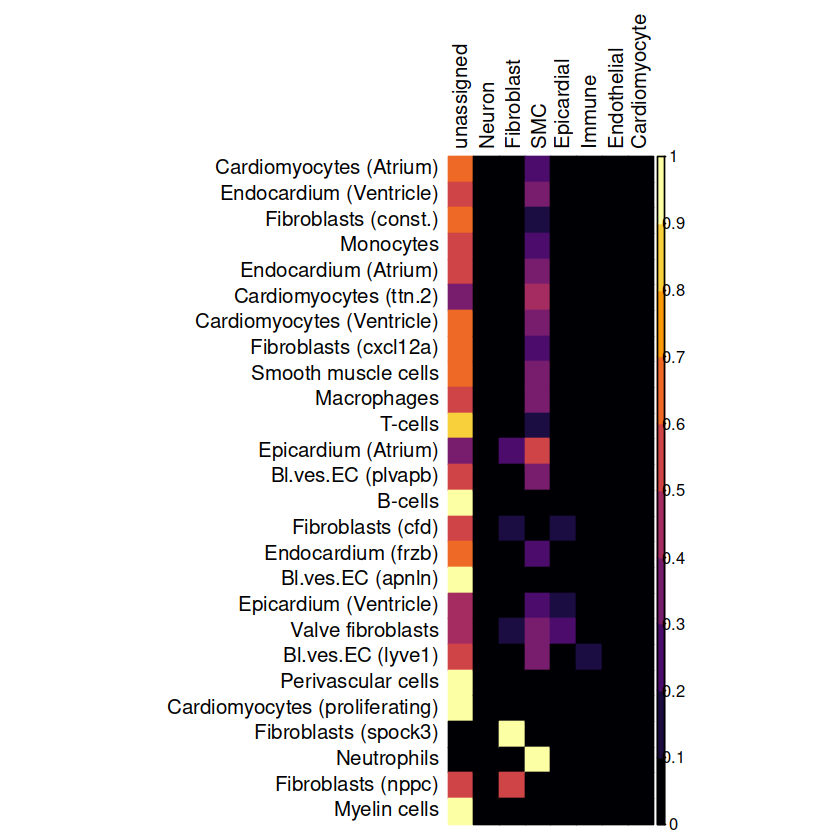

In [94]:
library(corrplot)
library(viridis)
my_palette = viridis::inferno(10)

# png(paste0('chick_D14_markerset_fraction.png'), width = 5, height = 5, res = 300, units = 'in')
# pdf('aa-bbs5-sc-5x5.pdf', width = 5, height = 5)
corrplot(outmat2, method = 'color', is.corr = F, col = my_palette, #col.lim = c(0,1),
         tl.col = 'black', na.label = ' ', na.label.col = 'white')
# dev.off()